# Setup

In [1]:
include(joinpath("..","src","setup.jl"))

┌ Info: Recompiling stale cache file /Users/davidlittle/.julia/compiled/v0.7/AuditoryBistabilityLE/RqG8S.ji for AuditoryBistabilityLE [7e25a372-ade5-11e8-17af-a30e5a9e2c28]
└ @ Base loading.jl:1185


RObject{VecSxp}
$rcalljl_options
$rcalljl_options$height
[1] 360

$rcalljl_options$width
[1] 432




In [2]:
paramfile = joinpath("..","data","count_lengths","run_2018-09-12",
                     "individual_extremes_params.feather")
params = getparams(paramfile) do i,row
  abs(row[:t_c_m] - 32) < 1 &&
  abs(row[:t_c_a] - 5) < 1 &&
  row[:Δf] == 12
end

params[:t_W_m_σ_t] = 7.0
params[:t_W_m_σ_ϕ] = 7.0
params[:t_W_m_c] = 4.0

settings = TOML.parsefile(joinpath(srcdir,"settings.toml"))
settings["track"]["analyze"]["freq_ridge"] = 2
settings["track"]["analyze"]["scale_ridge"] = 1e-6

1.0e-6

## some examples of the distance function for ridge definition

In [115]:
d = rdist(scale=1e-6,freq=3)
@show exp(-d((1,1),(1,1)))
@show exp(-d((1,1),(1,2)))
@show exp(-d((1,1),(1,3)))
@show exp(-d((1,1),(1,4)))
@show exp(-d((1,1),(1,5)))
@show exp(-d((1,1),(1,6)))
@show exp(-d((1,1),(2,1)))
@show exp(-d((1,1),(2,2)))
@show exp(-d((1,1),(2,3)))

exp(-(d((1, 1), (1, 1)))) = 1.0
exp(-(d((1, 1), (1, 2)))) = 0.8948393168143698
exp(-(d((1, 1), (1, 3)))) = 0.6411803884299546
exp(-(d((1, 1), (1, 4)))) = 0.36787944117144233
exp(-(d((1, 1), (1, 5)))) = 0.1690133154060661
exp(-(d((1, 1), (1, 6)))) = 0.06217652402211632
exp(-(d((1, 1), (2, 1)))) = 0.0
exp(-(d((1, 1), (2, 2)))) = 0.0
exp(-(d((1, 1), (2, 3)))) = 0.0


0.0

# initial simulation run

In [9]:
settings["track"]["analyze"]["max_sources"] = 2
settings["track"]["analyze"]["normalize"] = true
settings["track"]["analyze"]["min_norm"] = 1.0
settings["track"]["analyze"]["source_prior_strength_s"] = 0.2

result = []
for d in [1,3,6,12]
    params[:Δf] = d
    push!(result,bistable_model(15,params,settings,progressbar=false,
                                intermediate_results=true))
end

┌ Info: 2.78% of frames failed to fully converge to a solution.
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/nmf.jl:44
┌ Info: 1.39% of frames failed to fully converge to a solution.
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/nmf.jl:44


In [10]:
using Unitful
using AxisArrays

function pred(x,y)
    pr = deepcopy(result[1].sources.tracks[1].params.source_prior)
    like = zero(pr,prod((size(result[1].cohere,2),size(result[1].cohere,3))))
    AuditoryBistabilityLE.update!(like,vec(x))
    AuditoryBistabilityLE.logpdf(pr + like,vec(y))
end

pred (generic function with 1 method)

In [11]:
function fpred(f1,f2)
    a = AuditoryBistabilityLE.tone(f1,1s)
    b = AuditoryBistabilityLE.tone(f2,1s)
    set = AuditoryBistabilityLE.read_settings(settings)
    l,u = set.rates.freq_limits_Hz.*Hz
    A = cortical(audiospect(a;set.freqs.analyze...);set.scales.analyze...)[:,:,l .. u]
    B = cortical(audiospect(b;set.freqs.analyze...);set.scales.analyze...)[:,:,l .. u]
    pred(abs.(A[1,:,:]),abs.(B[1,:,:]))
end

fpred (generic function with 1 method)

# distances for actual frames

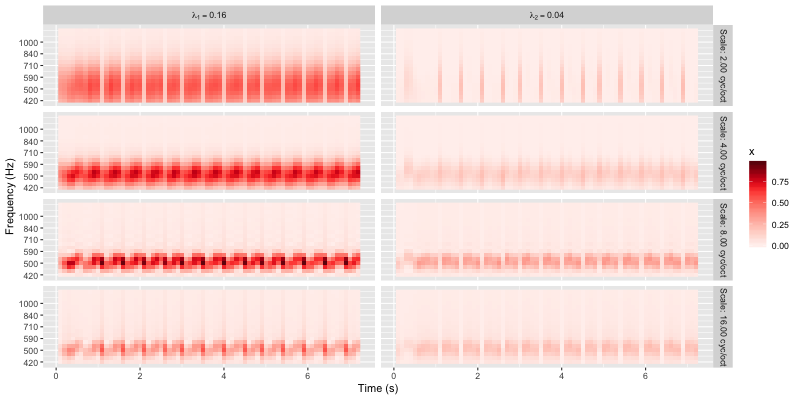

RObject{VecSxp}


In [12]:
rplot(result[1].cohere)

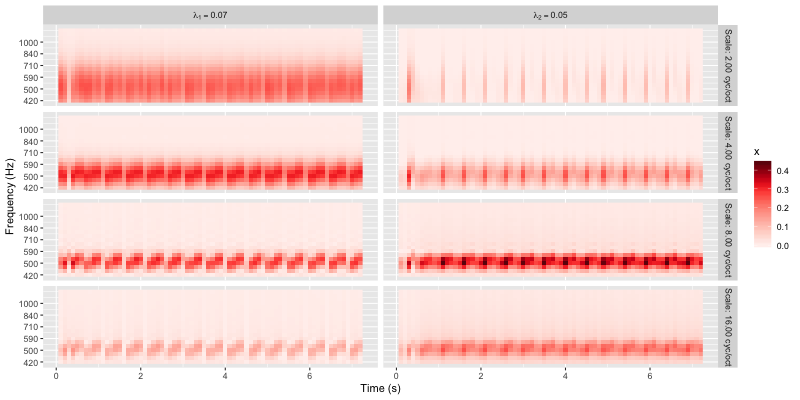

RObject{VecSxp}


In [13]:
rplot(result[1].sources.tracks[1])

In [14]:
sum(result[1].sources.tracks[1].params.source_prior.corr .> 0)

1004

In [15]:
sum(result[1].sources.tracks[1].params.source_prior.corr.data .> 0)

540

In [16]:
size(result[1].sources.tracks[1].params.source_prior.corr)

(76, 76)

┌ Warning: `indices(a, d)` is deprecated, use `axes(a, d)` instead.
│   caller = raster_plot(::LinearAlgebra.Symmetric{Float64,SparseArrays.SparseMatrixCSC{Float64,Int64}}) at rplots.jl:20
└ @ ShammaModel /Users/davidlittle/googledrive/juliadev/ShammaModel/src/rplots.jl:20
┌ Warning: `indices(a, d)` is deprecated, use `axes(a, d)` instead.
│   caller = raster_plot(::LinearAlgebra.Symmetric{Float64,SparseArrays.SparseMatrixCSC{Float64,Int64}}) at rplots.jl:20
└ @ ShammaModel /Users/davidlittle/googledrive/juliadev/ShammaModel/src/rplots.jl:20


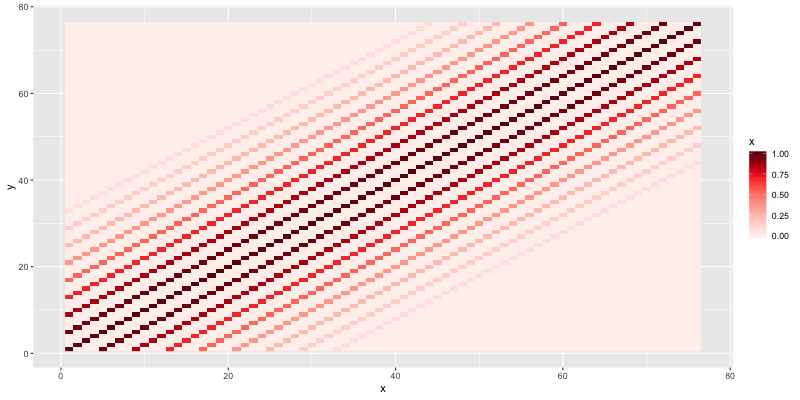

RObject{VecSxp}


In [17]:
ShammaModel.raster_plot(result[1].sources.tracks[1].params.source_prior.corr)

In [18]:
for i in 50:59
    @show pred(result[1].cohere[i,:,:,1],result[1].cohere[i+1,:,:,1])
end

pred((result[1]).cohere[i, :, :, 1], (result[1]).cohere[i + 1, :, :, 1]) = 122.02753422212717
pred((result[1]).cohere[i, :, :, 1], (result[1]).cohere[i + 1, :, :, 1]) = 119.97247586404694
pred((result[1]).cohere[i, :, :, 1], (result[1]).cohere[i + 1, :, :, 1]) = 138.586166681583
pred((result[1]).cohere[i, :, :, 1], (result[1]).cohere[i + 1, :, :, 1]) = 104.86746672558223
pred((result[1]).cohere[i, :, :, 1], (result[1]).cohere[i + 1, :, :, 1]) = 135.2975809506941
pred((result[1]).cohere[i, :, :, 1], (result[1]).cohere[i + 1, :, :, 1]) = 125.3360830032623
pred((result[1]).cohere[i, :, :, 1], (result[1]).cohere[i + 1, :, :, 1]) = 123.22430059962625
pred((result[1]).cohere[i, :, :, 1], (result[1]).cohere[i + 1, :, :, 1]) = 135.96130221791674
pred((result[1]).cohere[i, :, :, 1], (result[1]).cohere[i + 1, :, :, 1]) = 102.13649840480895
pred((result[1]).cohere[i, :, :, 1], (result[1]).cohere[i + 1, :, :, 1]) = 131.4570868599816


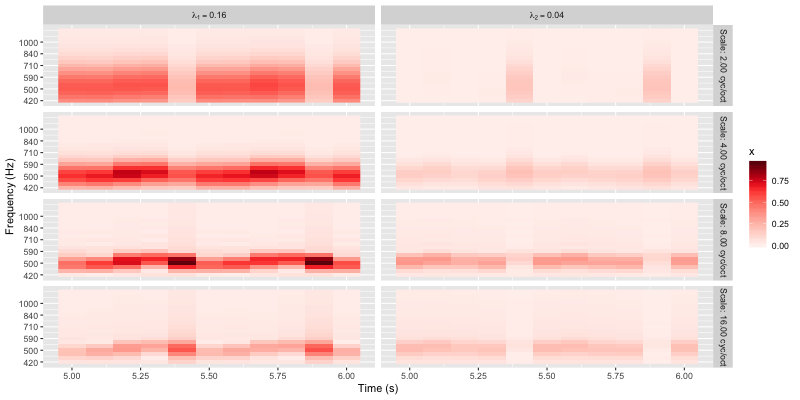

RObject{VecSxp}


In [19]:
rplot(result[1].cohere[50:60,:,:,:])

In [20]:
for i in 50:59
    @show pred(result[2].cohere[i,:,:,1],result[2].cohere[i+1,:,:,1])
end

pred((result[2]).cohere[i, :, :, 1], (result[2]).cohere[i + 1, :, :, 1]) = 107.96770979470546
pred((result[2]).cohere[i, :, :, 1], (result[2]).cohere[i + 1, :, :, 1]) = 127.67829985784942
pred((result[2]).cohere[i, :, :, 1], (result[2]).cohere[i + 1, :, :, 1]) = 127.18502216339041
pred((result[2]).cohere[i, :, :, 1], (result[2]).cohere[i + 1, :, :, 1]) = 87.60751135687957
pred((result[2]).cohere[i, :, :, 1], (result[2]).cohere[i + 1, :, :, 1]) = 112.39400761991072
pred((result[2]).cohere[i, :, :, 1], (result[2]).cohere[i + 1, :, :, 1]) = 107.05695469403128
pred((result[2]).cohere[i, :, :, 1], (result[2]).cohere[i + 1, :, :, 1]) = 150.2025813718614
pred((result[2]).cohere[i, :, :, 1], (result[2]).cohere[i + 1, :, :, 1]) = 132.8984898252859
pred((result[2]).cohere[i, :, :, 1], (result[2]).cohere[i + 1, :, :, 1]) = 85.96257502815794
pred((result[2]).cohere[i, :, :, 1], (result[2]).cohere[i + 1, :, :, 1]) = 114.9301527775772


In [21]:
for i in 50:59
    @show pred(result[3].cohere[i,:,:,1],result[3].cohere[i+1,:,:,1])
end

pred((result[3]).cohere[i, :, :, 1], (result[3]).cohere[i + 1, :, :, 1]) = 105.19340889741773
pred((result[3]).cohere[i, :, :, 1], (result[3]).cohere[i + 1, :, :, 1]) = 95.52880610627977
pred((result[3]).cohere[i, :, :, 1], (result[3]).cohere[i + 1, :, :, 1]) = 120.1255324646958
pred((result[3]).cohere[i, :, :, 1], (result[3]).cohere[i + 1, :, :, 1]) = 113.61092570619707
pred((result[3]).cohere[i, :, :, 1], (result[3]).cohere[i + 1, :, :, 1]) = 103.6350840760914
pred((result[3]).cohere[i, :, :, 1], (result[3]).cohere[i + 1, :, :, 1]) = 105.62053061731578
pred((result[3]).cohere[i, :, :, 1], (result[3]).cohere[i + 1, :, :, 1]) = 94.46306316083138
pred((result[3]).cohere[i, :, :, 1], (result[3]).cohere[i + 1, :, :, 1]) = 111.84388846702123
pred((result[3]).cohere[i, :, :, 1], (result[3]).cohere[i + 1, :, :, 1]) = 81.90681448037955
pred((result[3]).cohere[i, :, :, 1], (result[3]).cohere[i + 1, :, :, 1]) = 105.38446346498066


In [22]:
for i in 50:59
    @show pred(result[4].cohere[i,:,:,1],result[4].cohere[i+1,:,:,1])
end

pred((result[4]).cohere[i, :, :, 1], (result[4]).cohere[i + 1, :, :, 1]) = 101.97112822600832
pred((result[4]).cohere[i, :, :, 1], (result[4]).cohere[i + 1, :, :, 1]) = 90.61765037703319
pred((result[4]).cohere[i, :, :, 1], (result[4]).cohere[i + 1, :, :, 1]) = 92.76170236046644
pred((result[4]).cohere[i, :, :, 1], (result[4]).cohere[i + 1, :, :, 1]) = 102.57236359247855
pred((result[4]).cohere[i, :, :, 1], (result[4]).cohere[i + 1, :, :, 1]) = 72.70745332522858
pred((result[4]).cohere[i, :, :, 1], (result[4]).cohere[i + 1, :, :, 1]) = 98.71958121589125
pred((result[4]).cohere[i, :, :, 1], (result[4]).cohere[i + 1, :, :, 1]) = 86.35674436693685
pred((result[4]).cohere[i, :, :, 1], (result[4]).cohere[i + 1, :, :, 1]) = 89.7657658160212
pred((result[4]).cohere[i, :, :, 1], (result[4]).cohere[i + 1, :, :, 1]) = 102.04889971541891
pred((result[4]).cohere[i, :, :, 1], (result[4]).cohere[i + 1, :, :, 1]) = 75.2984858576281


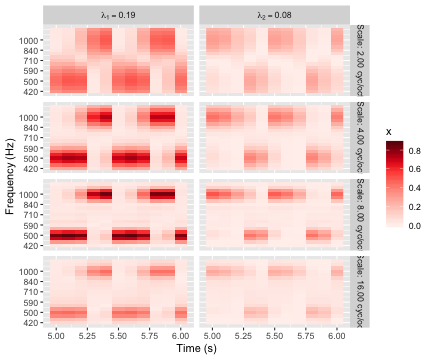

RObject{VecSxp}


In [169]:
rplot(result[4].cohere[50:60,:,:,:])

# explore prior effect on distances of simplified frames

In [23]:
function pred(sd,N,x,y)
    pr = AuditoryBistabilityLE.ridgenorm(sd,N,(size(x,1),size(x,2)), freq=2, scale=1e-6, threshold=0.05)
    like = zero(pr,size(x,1)*size(x,2))
    AuditoryBistabilityLE.update!(like,vec(x))
    AuditoryBistabilityLE.logpdf(pr + like,vec(y))
end

pred (generic function with 2 methods)

In [24]:
function fpred(sd,N,f1,f2)
    a = AuditoryBistabilityLE.tone(f1,1s)
    b = AuditoryBistabilityLE.tone(f2,1s)
    set = AuditoryBistabilityLE.read_settings(settings)
    l,u = set.rates.freq_limits_Hz.*Hz
    A = cortical(audiospect(a;set.freqs.analyze...);set.scales.analyze...)[:,:,l .. u]
    B = cortical(audiospect(b;set.freqs.analyze...);set.scales.analyze...)[:,:,l .. u]
    pred(sd,N,abs.(A[1,:,:]),abs.(B[1,:,:]))
end

fpred (generic function with 2 methods)

Auditory Spectrogram: 100%|█████████████████████████████| Time: 0:00:00


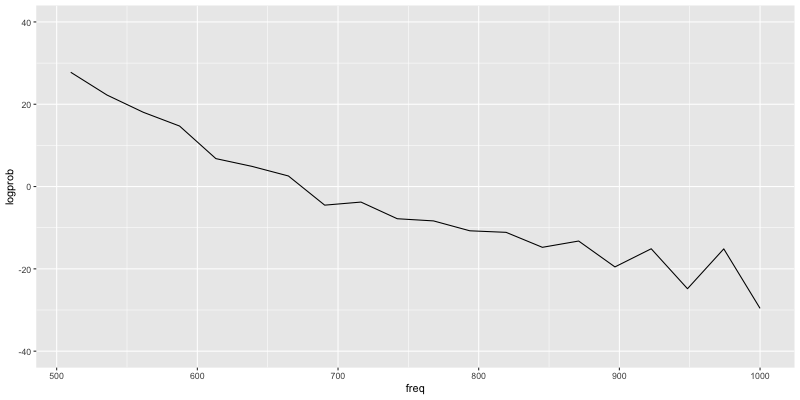

RObject{VecSxp}


In [25]:
fs = range(510,stop=1000,length=20)
vals = map(fs) do f
    fpred(4.0,4,500Hz,f*Hz)
end
R"""qplot(x=$fs,y=$vals,geom='line') + xlab('freq') + ylab('logprob') + ylim(-40,40)"""

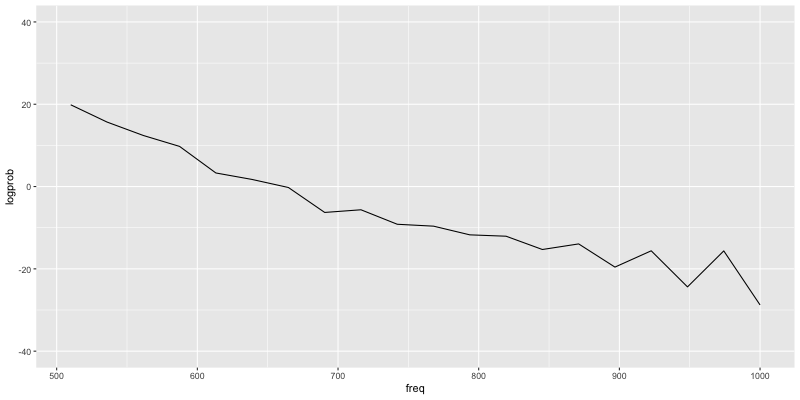

RObject{VecSxp}


In [26]:
fs = range(510,stop=1000,length=20)
vals = map(fs) do f
    fpred(16.0,4,500Hz,f*Hz)
end
R"""qplot(x=$fs,y=$vals,geom='line') + xlab('freq') + ylab('logprob') + ylim(-40,40)"""

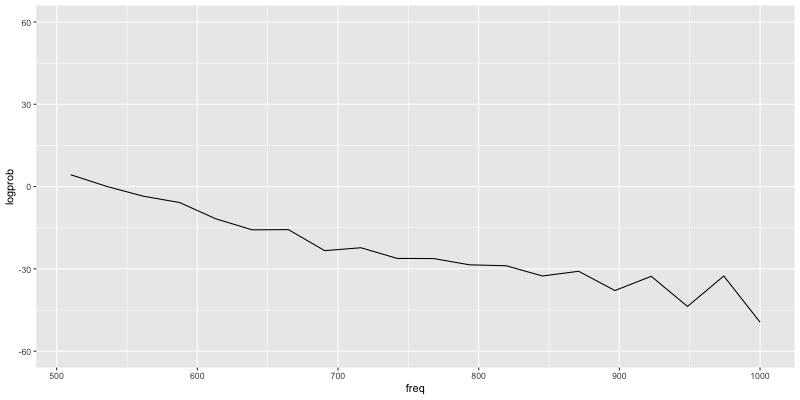

RObject{VecSxp}


In [27]:
fs = range(510,stop=1000,length=20)
vals = map(fs) do f
    fpred(4.0,16,500Hz,f*Hz)
end
R"""qplot(x=$fs,y=$vals,geom='line') + xlab('freq') + ylab('logprob') + ylim(-60,60)"""

# Discussion

The effect seems to fit intuition here. It may just be that the range of priors considered is not large enough. Let's look at some more examples on the real data.

# Effect of prior on tracking

In [47]:
settings = TOML.parsefile(joinpath(srcdir,"settings.toml"))
settings["track"]["analyze"]["freq_ridge"] = 5.0
settings["track"]["analyze"]["scale_ridge"] = 1e-8
settings["track"]["analyze"]["source_prior_sds"] = range(200,stop=210,length=10)
settings["track"]["analyze"]["source_prior_strength_s"] = 0.5
settings["track"]["analyze"]["time_constants_s"] = [0.5]

settings["track"]["analyze"]["max_sources"] = 2
settings["track"]["analyze"]["normalize"] = true
settings["track"]["analyze"]["min_norm"] = 0.2

result = []
for d in [1,3,6,12]
    @show d
    params[:Δf] = d
    push!(result,bistable_model(15,params,settings,progressbar=false,
                                intermediate_results=true))
end

d = 1


┌ Info: 2.78% of frames failed to fully converge to a solution.
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/nmf.jl:44


d = 3
d = 6


┌ Info: 1.39% of frames failed to fully converge to a solution.
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/nmf.jl:44


d = 12


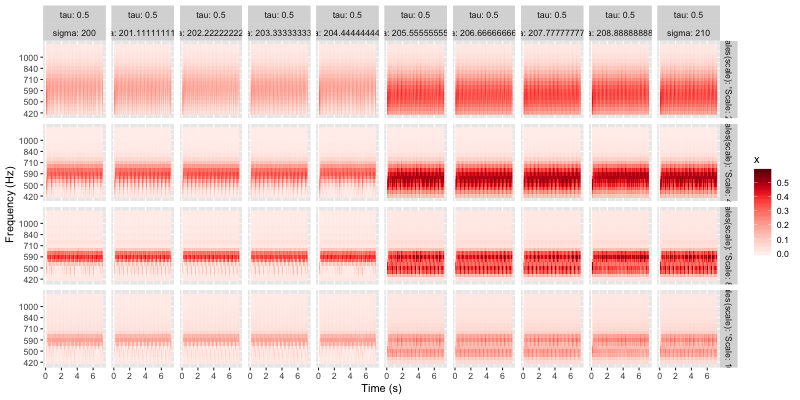

RObject{VecSxp}


In [48]:
rplot(result[2].sources.tracks)

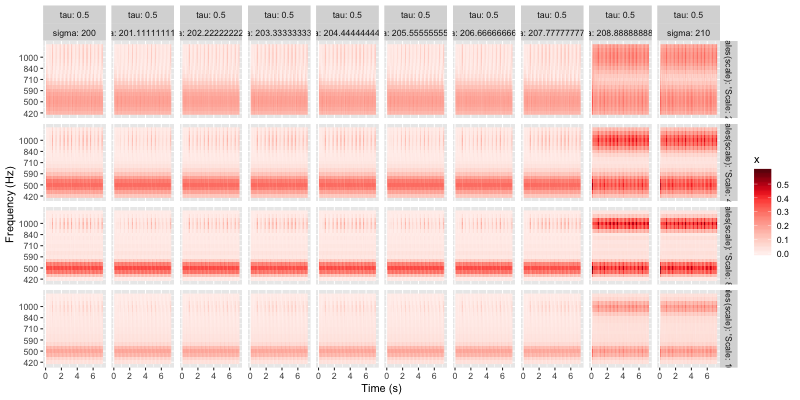

RObject{VecSxp}


In [49]:
rplot(result[4].sources.tracks)

# thoughts

so there is a difference, and it even happens in the right direction: the larger separation stays split for higher levels of variance. However,
the particular magnitudes and precision invovled seems somewhat non-sensical. Why 200??? This is so far from the magnitudes of the actual individual responses (within 0.5), and with this large mangitude, the proportional change in prior to see a differnce in the two $\Delta f$ values is so small.

In [27]:
function showtrack(i)
    println(AxisArrays.axes(result[2].sources.tracks)[1][i])
    rplot(result[2].sources.tracks[i])
end

showtrack (generic function with 1 method)

# possible plans

First, find the fused and split frames. Then, I need a function to compute the logpdf of each new frame (given the process of inference that would have generated the frames to this point) for a given prior.

NOTE: changed code and re-ran above model simulations

# NOTES:

the below results revealed that there were issues with the computation of the logpdf. The present error has been fixed, and now I need to go back and retest some things

(might be worth creating some unit tests for this problem)

In [69]:
fieldnames(typeof(result[2].sources))

(:tracks, :groupings, :result, :inweights, :outweights, :adapt, :inhibit)

In [74]:
AuditoryBistabilityLE.prediction(result[2],3;method=:multi_prior,AuditoryBistabilityLE.read_settings(settings).track.analyze...)

MethodError: MethodError: no method matching lu!(::SparseArrays.SparseMatrixCSC{Float64,Int64}, ::Val{true}; check=true)
Closest candidates are:
  lu!(!Matched::Union{DenseArray{T<:Union{Complex{Float32}, Complex{Float64}, Float32, Float64},2}, ReinterpretArray{T<:Union{Complex{Float32}, Complex{Float64}, Float32, Float64},2,S,A} where S where A<:Union{SubArray{T,N,A,I,true} where I<:Tuple{AbstractUnitRange,Vararg{Any,N} where N} where A<:DenseArray where N where T, DenseArray}, ReshapedArray{T<:Union{Complex{Float32}, Complex{Float64}, Float32, Float64},2,A,MI} where MI<:Tuple{Vararg{SignedMultiplicativeInverse{Int64},N} where N} where A<:Union{ReinterpretArray{T,N,S,A} where S where A<:Union{SubArray{T,N,A,I,true} where I<:Tuple{AbstractUnitRange,Vararg{Any,N} where N} where A<:DenseArray where N where T, DenseArray} where N where T, SubArray{T,N,A,I,true} where I<:Tuple{AbstractUnitRange,Vararg{Any,N} where N} where A<:DenseArray where N where T, DenseArray}, SubArray{T<:Union{Complex{Float32}, Complex{Float64}, Float32, Float64},2,A,I,L} where L where I<:Tuple{Vararg{Union{Int64, AbstractRange{Int64}, AbstractCartesianIndex},N} where N} where A<:Union{ReinterpretArray{T,N,S,A} where S where A<:Union{SubArray{T,N,A,I,true} where I<:Tuple{AbstractUnitRange,Vararg{Any,N} where N} where A<:DenseArray where N where T, DenseArray} where N where T, ReshapedArray{T,N,A,MI} where MI<:Tuple{Vararg{SignedMultiplicativeInverse{Int64},N} where N} where A<:Union{ReinterpretArray{T,N,S,A} where S where A<:Union{SubArray{T,N,A,I,true} where I<:Tuple{AbstractUnitRange,Vararg{Any,N} where N} where A<:DenseArray where N where T, DenseArray} where N where T, SubArray{T,N,A,I,true} where I<:Tuple{AbstractUnitRange,Vararg{Any,N} where N} where A<:DenseArray where N where T, DenseArray} where N where T, DenseArray}}, ::Union{Val{false}, Val{true}}; check) where T<:Union{Complex{Float32}, Complex{Float64}, Float32, Float64} at /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v0.7/LinearAlgebra/src/lu.jl:37
  lu!(!Matched::Union{Hermitian{T,S}, Symmetric{T,S}} where S where T, ::Union{Val{false}, Val{true}}; check) at /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v0.7/LinearAlgebra/src/lu.jl:45
  lu!(!Matched::Union{DenseArray{T,2}, ReinterpretArray{T,2,S,A} where S where A<:Union{SubArray{T,N,A,I,true} where I<:Tuple{AbstractUnitRange,Vararg{Any,N} where N} where A<:DenseArray where N where T, DenseArray}, ReshapedArray{T,2,A,MI} where MI<:Tuple{Vararg{SignedMultiplicativeInverse{Int64},N} where N} where A<:Union{ReinterpretArray{T,N,S,A} where S where A<:Union{SubArray{T,N,A,I,true} where I<:Tuple{AbstractUnitRange,Vararg{Any,N} where N} where A<:DenseArray where N where T, DenseArray} where N where T, SubArray{T,N,A,I,true} where I<:Tuple{AbstractUnitRange,Vararg{Any,N} where N} where A<:DenseArray where N where T, DenseArray}, SubArray{T,2,A,I,L} where L where I<:Tuple{Vararg{Union{Int64, AbstractRange{Int64}, AbstractCartesianIndex},N} where N} where A<:Union{ReinterpretArray{T,N,S,A} where S where A<:Union{SubArray{T,N,A,I,true} where I<:Tuple{AbstractUnitRange,Vararg{Any,N} where N} where A<:DenseArray where N where T, DenseArray} where N where T, ReshapedArray{T,N,A,MI} where MI<:Tuple{Vararg{SignedMultiplicativeInverse{Int64},N} where N} where A<:Union{ReinterpretArray{T,N,S,A} where S where A<:Union{SubArray{T,N,A,I,true} where I<:Tuple{AbstractUnitRange,Vararg{Any,N} where N} where A<:DenseArray where N where T, DenseArray} where N where T, SubArray{T,N,A,I,true} where I<:Tuple{AbstractUnitRange,Vararg{Any,N} where N} where A<:DenseArray where N where T, DenseArray} where N where T, DenseArray}} where T, ::Union{Val{false}, Val{true}}; check) at /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v0.7/LinearAlgebra/src/lu.jl:86
  ...

# Old work...

# Percept testing

In [223]:
settings = TOML.parsefile(joinpath(src,"settings.toml"))
settings["track"]["analyze"]["freq_ridge"] = 3.5
settings["track"]["analyze"]["scale_ridge"] = 1e-8
settings["track"]["analyze"]["source_prior_sds"] = [4.0,16.0,32.0,64.0,128.0]
settings["track"]["analyze"]["time_constants_s"] = [1.0,8.0,16.0]

settings["track"]["analyze"]["max_sources"] = 2
settings["track"]["analyze"]["normalize"] = true
settings["track"]["analyze"]["min_norm"] = 0.2

result = []
for d in [1,3,6,12]
 params[:Δf] = d
  push!(result,bistable_model(15,params,settings,progressbar=false,
                              intermediate_results=true))
end

┌ Warning: Deprecated syntax `implicit assignment to global variable `d``.
│ Use `global d` instead.
└ @ nothing none:0
┌ Warning: Loop variable `d` around In[223]:12 overwrites a variable in an enclosing scope. In the future the variable will be local to the loop instead.
└ @ nothing In[223]:12
┌ Info: 2.78% of frames failed to fully converge to a solution.
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/nmf.jl:44
┌ Info: Sparsity of source-prior (76 × 76) ridge: 448 (8%)
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/priors/ridge_norm.jl:31
┌ Info: Sparsity of source-prior (76 × 76) ridge: 448 (8%)
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/priors/ridge_norm.jl:31
┌ Info: Sparsity of source-prior (76 × 76) ridge: 448 (8%)
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/priors/ridge_norm.jl:31
┌ Info: Spar

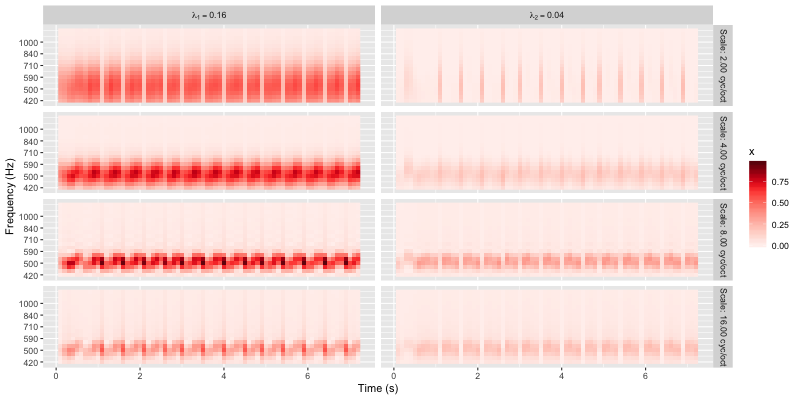

RObject{VecSxp}


In [224]:
rplot(result[1].cohere)

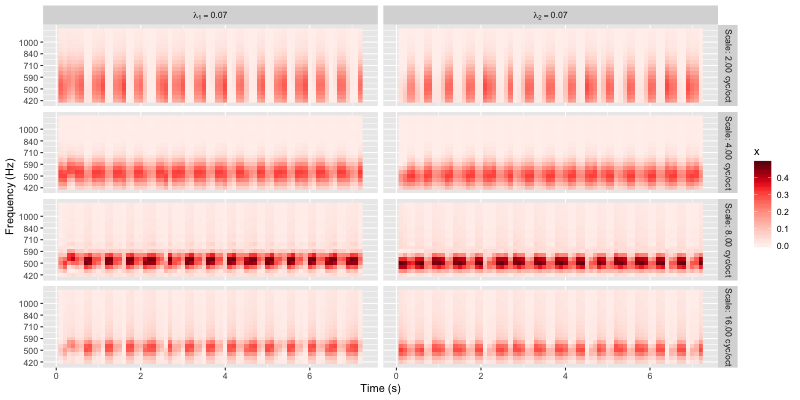

RObject{VecSxp}


In [225]:
rplot(result[1].sources.tracks[1])

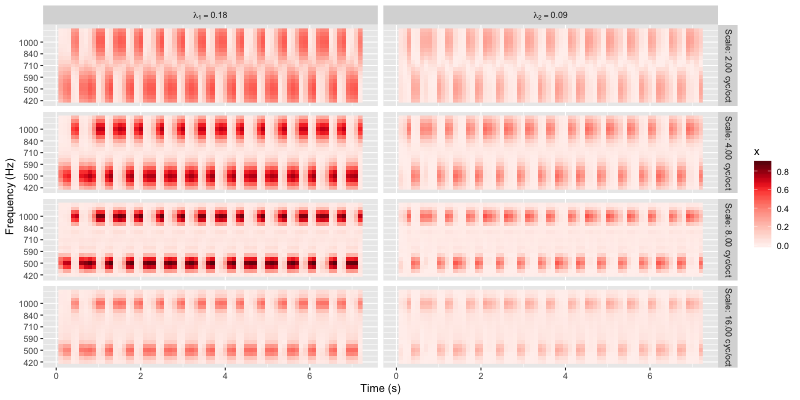

RObject{VecSxp}


In [227]:
rplot(result[4].cohere)

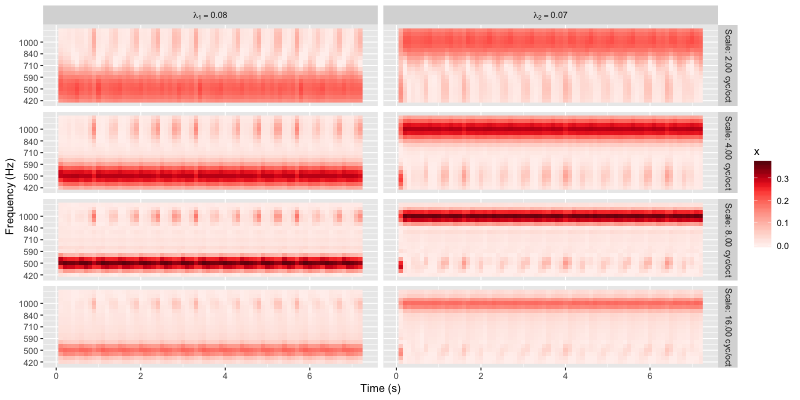

RObject{VecSxp}


In [228]:
rplot(result[4].sources.tracks[1])

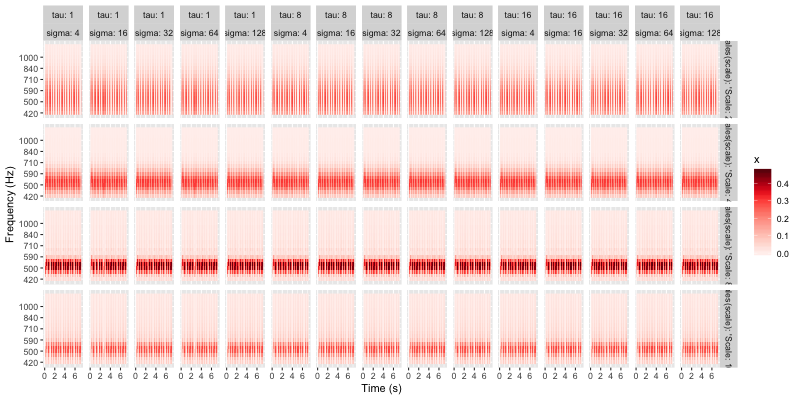

RObject{VecSxp}


In [229]:
rplot(result[1].sources.tracks)

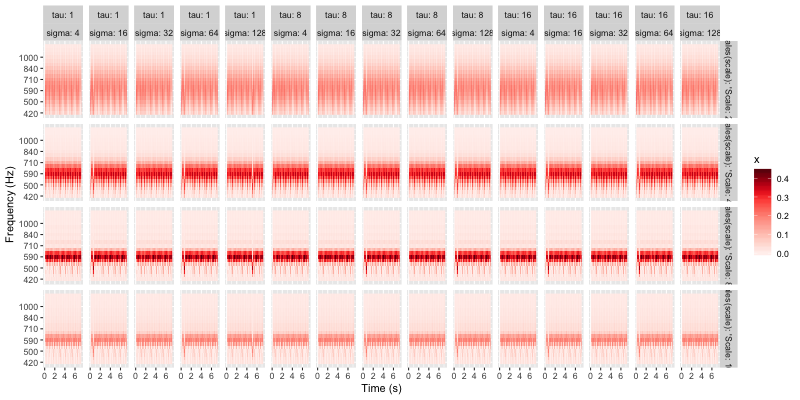

RObject{VecSxp}


In [230]:
rplot(result[2].sources.tracks)

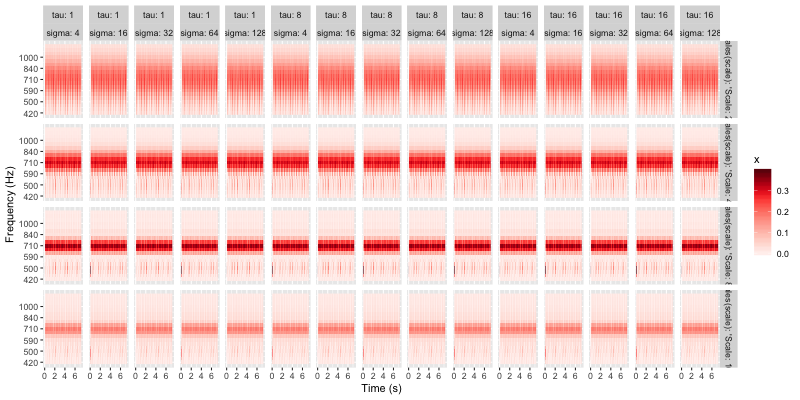

RObject{VecSxp}


In [231]:
rplot(result[3].sources.tracks)

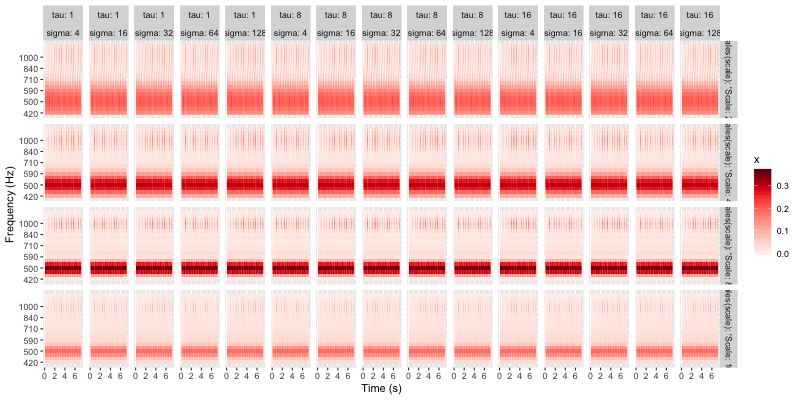

RObject{VecSxp}


In [232]:
rplot(result[4].sources.tracks)

## Discussion

Although the probabilities found by `pred` and `fpred` are consistent with my intuition, the consequences of the prior on this probability do not seem to be matching my intuition. I need to examine the effect of the prior on the measures and see if there is a reasonable aspect of the prior to maniuplate:
one obvious thing might be to alter the extent of the neighborhood in the correlation matrix: however this would invovle more computations.

Principally, by increasing the neibhord, basically all of the percepts are split. (Not that that with a narrower neighbord hood 1st percept fuses)

1. I might explore this by exmaining $\Delta f$ values closer to one another, as it seems like 3st, 6st an 12st are all essentially equivalent to one another still. Perhaps this would work if I just squeeze the delta t's. 

2. Another possibility is that I could examine the effect of the prior on `pred` and `fpred`.


### Distilled Plans

1. make a plot for simulated data, like above, only for different priors


Depending on the outcome of that I might also:

2. explore different $\Delta f$ values
3. consider different neighborhoods for the ridge